In [1]:
from typing import Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, GRU, Dense

2022-10-11 22:54:49.001971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 22:54:49.157516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 22:54:49.157540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 22:54:49.189612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 22:54:50.040110: W tensorflow/stream_executor/platform/de

In [2]:
train = pd.read_csv('data/DailyDelhiClimateTrain.csv',index_col='date',parse_dates=True)
test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [4]:
train.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
def plot_decomp(ip, ax):
    
    ip.observed.plot(ax=ax[0])
    ax[0].set_ylabel("Observed")

    ip.trend.plot(ax=ax[1], color='red')
    ax[1].set_ylabel("Trend")

    ip.seasonal.plot(ax=ax[2], color='green')
    ax[2].set_ylabel("Seasonality")

    ip.resid.plot(ax=ax[3], color='orange')
    ax[3].set_ylabel("Residual")

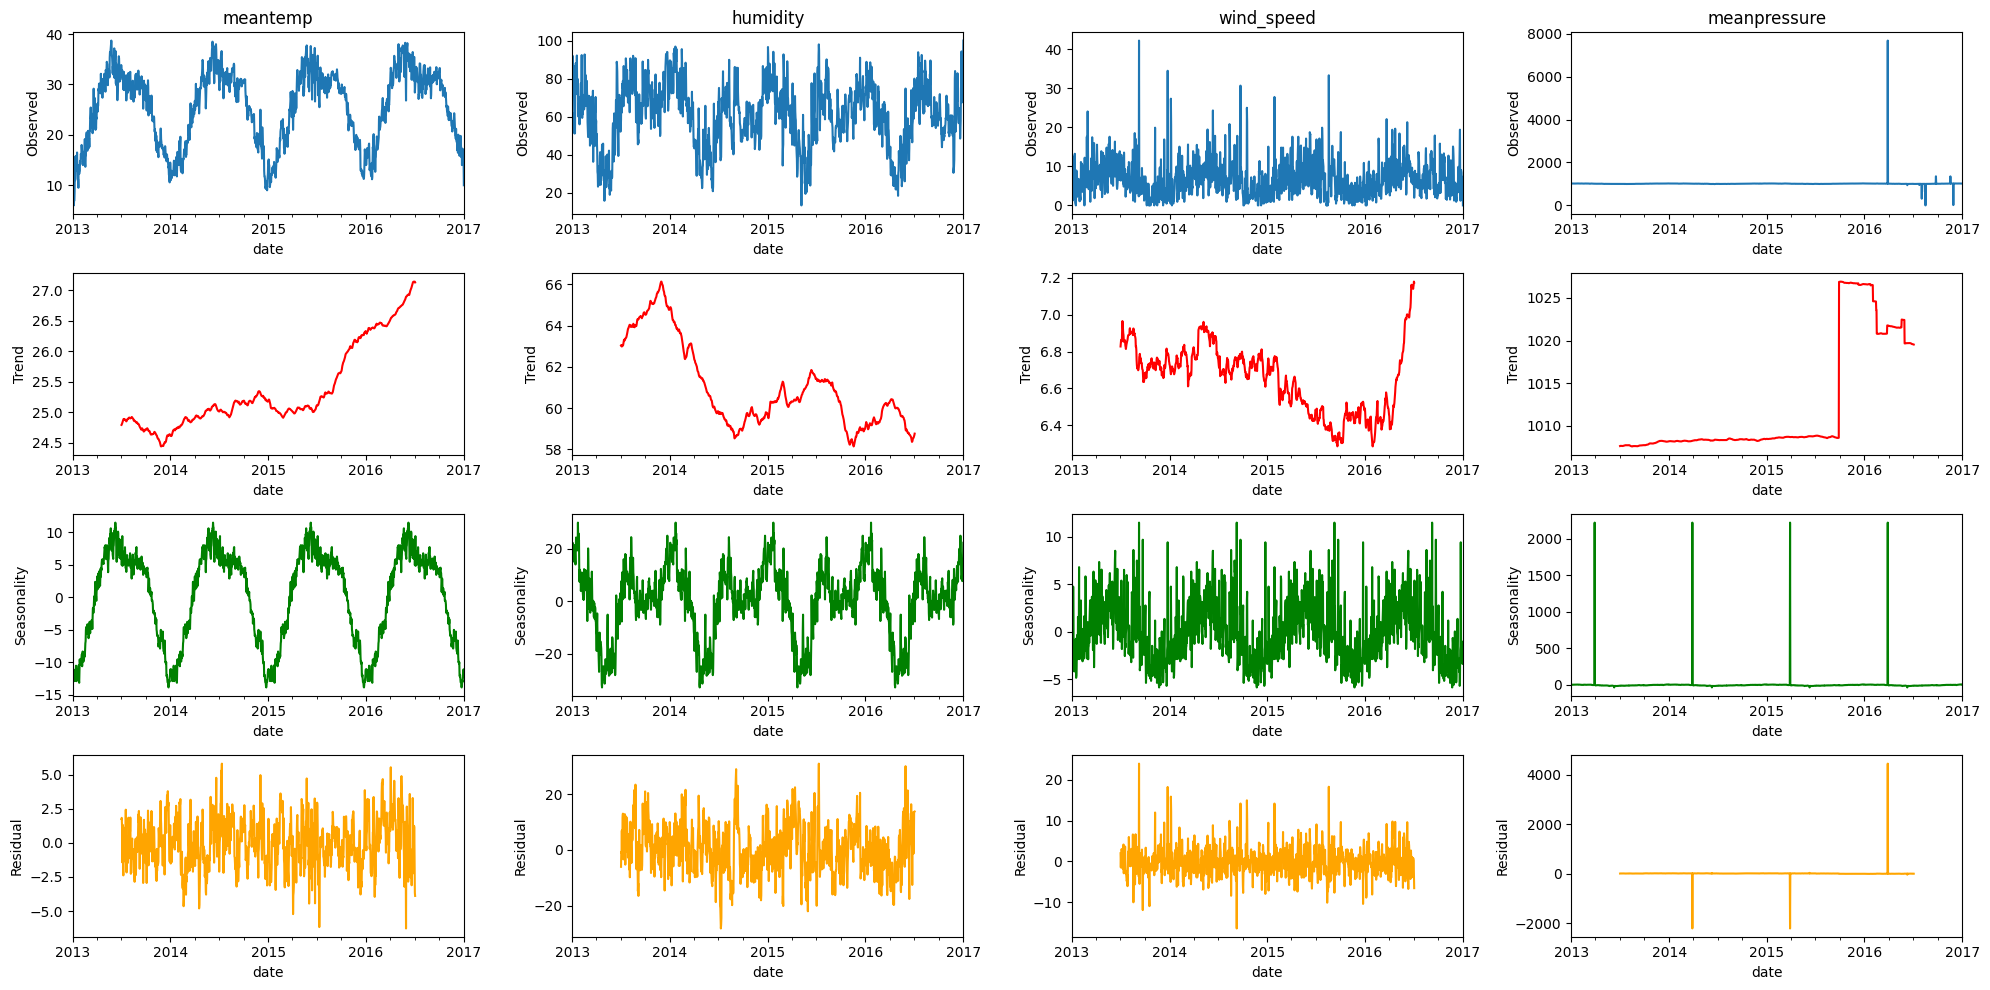

In [6]:
fig, ax = plt.subplots(4,4,figsize=(20,10))

for i,col in enumerate(train.columns):
    ip = seasonal_decompose(train[col], period=365)
    plot_decomp(ip, ax[: ,i%4])
    ax[0][i%4].set_title(col)

plt.tight_layout()
plt.show()

#### 1. Scaling

In [7]:
scaler = StandardScaler()
train_sc = scaler.fit_transform(train)
scaled_train = pd.DataFrame(train_sc, columns=train.columns.tolist())

In [8]:
scaled_train.head()

,meantemp,humidity,wind_speed,meanpressure
0,-2.109500,1.415439,-1.491699,0.025321
1,-2.463454,1.862828,-0.838196,0.037162
2,-2.495219,1.564569,-0.475626,0.041972
3,-2.291015,0.630022,-1.221233,0.033647
4,-2.654044,1.554627,-0.680303,0.029946


#### 2. Creating Rolling Window for generating Features and Target variables

In [9]:
def create_rolling_window(data, window=1):
    x, y = list(), list()
    for i in range(window, len(data)):
        temp = data[i-window:i].reshape(window,1)
        x.append(temp)
        y.append(data[i].reshape(1))
    return np.array(x), np.array(y)

#### 3. Building Model

In [10]:
def create_model():
    model = Sequential()
    model.add(LSTM(8, input_shape=(10,1,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

#### 4. Prepare data for model

In [11]:
x_temp, y_temp = create_rolling_window(scaled_train['meantemp'].values,10)


In [12]:
x_temp.shape

(1452, 10, 1)

In [13]:
# Split into train and validation dataset
val_size = int(len(x_temp) * 0.9)

x_train = x_temp[0:val_size]
y_train = y_temp[0:val_size]
x_val = x_temp[val_size: len(x_temp)]
y_val = y_temp[val_size: len(x_temp)]

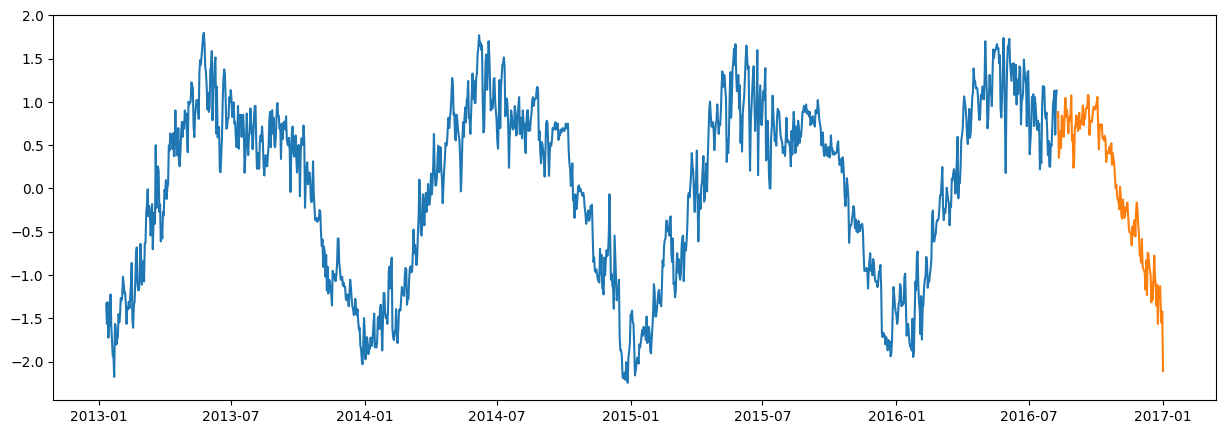

In [14]:
plt.figure(figsize=(15,5))
plt.plot(train.index[10:len(y_train)+10], y_train[:,0],label='Train')
plt.plot(train.index[10+len(y_train):], y_val[:,0],label='Validation')
plt.show()

#### 5. Model fit and Predictiom

In [15]:
model = create_model()
result = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50)

2022-10-11 22:54:54.468672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-11 22:54:54.468711: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 22:54:54.468733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dhanavikram-laptop): /proc/driver/nvidia/version does not exist
2022-10-11 22:54:54.468960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
41/41 [==============================] - 3s 19ms/step - loss: 0.7902 - val_loss: 0.2737
Epoch 2/50
41/41 [==============================] - 0s 6ms/step - loss: 0.2288 - val_loss: 0.0622
Epoch 3/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0840 - val_loss: 0.0444
Epoch 4/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0725 - val_loss: 0.0388
Epoch 5/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0636 - val_loss: 0.0356
Epoch 6/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0601 - val_loss: 0.0328
Epoch 7/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0590 - val_loss: 0.0320
Epoch 8/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0581 - val_loss: 0.0318
Epoch 9/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0566 - val_loss: 0.0340
Epoch 10/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0579 - val_loss: 0.0390
Epoch 11/50
41/41 

In [16]:
def predict(scaler, model, test, prediction_col, col_names):

    test = pd.DataFrame(scaler.transform(test), columns=col_names)
    x_test, y_test = create_rolling_window(test[prediction_col].values, 10)
    y_pred = model.predict(x_test)

    return y_pred, y_test

In [17]:
y_pred, y_test = predict(scaler, model, test, 'meantemp', train.columns.tolist())

4/4 [==============================] - 0s 3ms/step


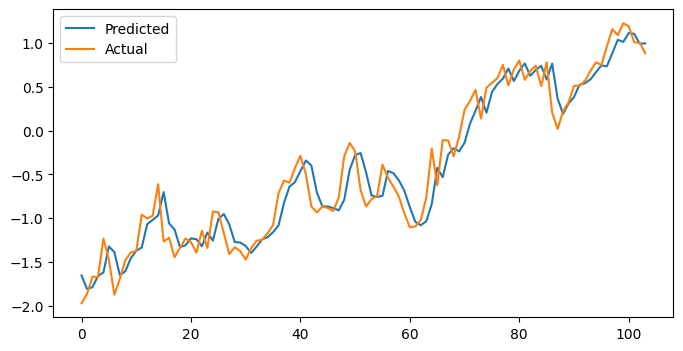

In [18]:
plt.figure(figsize=(8,4))
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()
plt.show()